In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from rdkit import Chem
import rdkit
import torch
from torch_geometric.utils import dense_to_sparse
from graph_transformer import GraphTransformer
import torch.nn as nn
import torch.nn.functional as F


# Function for handling molecules in graph format

In [11]:
atom_vocab = ['C', 'O', 'N', 'F', 'Cl', 'Br', 'I', 'S']
bond_vocab = [None, rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.TRIPLE]

def get_dense_features_from_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    graph = torch.tensor(Chem.GetAdjacencyMatrix(mol)).long()
    node_features = torch.tensor([atom_vocab.index(atom.GetSymbol()) for atom in mol.GetAtoms()]).long()
    # get dense graph
    x_features = F.one_hot(node_features, num_classes=len(atom_vocab)).float()
    e_features = F.one_hot(graph, num_classes=len(bond_vocab)).float()
    y_features = torch.zeros(1,1).float()
    node_mask = torch.ones(x_features.shape[0]).bool()

    return x_features.unsqueeze(0), e_features.unsqueeze(0), y_features, node_mask.unsqueeze(0)

def get_smiles_from_dense_features(nodes, edges):
    #E = F.softmax(graph.E, dim=-1)
    out_edge_index, out_edge_attr = dense_to_sparse(edges)
    # turn into smiles molecule
    mol = Chem.RWMol()
    for i, atom_c in enumerate(nodes.squeeze()):
        atom = Chem.Atom(atom_vocab[int(atom_c)])
        mol.AddAtom(atom)

    # add bonds
    edge_set = []
    for i, bond_type in enumerate(out_edge_attr):
        if set((int(out_edge_index[0][i]), int(out_edge_index[1][i]))) in edge_set:
            continue
        edge_set.append(set((int(out_edge_index[0][i]), int(out_edge_index[1][i]))))
        mol.AddBond(int(out_edge_index[0][i].item()), int(out_edge_index[1][i].item()), bond_vocab[int(bond_type)])

    m = mol.GetMol()
    smiles = Chem.MolToSmiles(m)

    return smiles, m

In [12]:
in_smiles = 'C1OCOCO1'
x_features, e_features, y_features, node_mask = get_dense_features_from_smiles(in_smiles)
smiles, m = get_smiles_from_dense_features(nodes=x_features.argmax(dim=-1), edges=e_features.argmax(dim=-1))
assert smiles==in_smiles, 'Something is wrong when encoding the molecule'

# Training

In [13]:
in_smiles = 'C1OCOCO1'
out_smiles = 'O=C(Cl)CC(O)'
use_pe = True # NOTE: change this to try without positional encodings
epochs = 1000
print_every = 50
pred_idx = 2

In [14]:
in_x_features, in_e_features, in_y_features, in_node_mask = get_dense_features_from_smiles(smiles=in_smiles)
out_x_features, out_e_features, out_y_features, out_node_mask = get_dense_features_from_smiles(smiles=out_smiles)

In [15]:
model = GraphTransformer(n_layers=5,  # More layers
                        input_dims={'X': in_x_features.shape[-1], 'E': in_e_features.shape[-1], 'y': 1}, 
                        hidden_mlp_dims={'X': 32, 'E': 128, 'y': 16},  # Larger for edges
                        hidden_dims={
                            'dx': 32, 
                            'de': 128,  # Much larger for edges
                            'dy': 16, 
                            'n_head': 4, 
                            'dim_ffX': 64, 
                            'dim_ffE': 128  # Larger feed-forward for edges
                        }, 
                        output_dims={'X': out_x_features.shape[-1], 'E': out_e_features.shape[-1], 'y': 1}, 
                        act_fn_in=nn.LeakyReLU(0.1),  # Try LeakyReLU to avoid dying ReLUs
                        act_fn_out=nn.LeakyReLU(0.1),
                        addition=False)  # Try without residual connections first

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lambda_e = .1

for e in range(epochs):
    train_graph = model(X=in_x_features, 
                        E=in_e_features, 
                        y=in_y_features, 
                        node_mask=in_node_mask,
                        use_pe=use_pe)
    x_target = out_x_features.argmax(dim=-1)  # Convert one-hot to indices
    e_target = out_e_features.argmax(dim=-1)  # Convert one-hot to indices
    
    # Calculate loss for each component
    x_loss = loss_fn(train_graph.X.reshape(-1, train_graph.X.shape[-1]), x_target.reshape(-1))
    e_loss = loss_fn(train_graph.E.reshape(-1, train_graph.E.shape[-1]), e_target.reshape(-1))

    # Total loss
    loss = x_loss + lambda_e*e_loss 
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    if e % print_every == 0:
        print(f'epoch {e} loss: {loss.item()}')


epoch 0 loss: 2.1295204162597656
epoch 50 loss: 0.7837392687797546
epoch 100 loss: 0.2641923129558563
epoch 150 loss: 0.052310120314359665
epoch 200 loss: 0.02939585968852043
epoch 250 loss: 0.0353541299700737
epoch 300 loss: 0.011216741986572742
epoch 350 loss: 0.014168841764330864
epoch 400 loss: 0.02094941958785057
epoch 450 loss: 0.015783805400133133
epoch 500 loss: 0.009087944403290749
epoch 550 loss: 0.01094951294362545
epoch 600 loss: 0.004658202175050974
epoch 650 loss: 0.004784044343978167
epoch 700 loss: 0.0022282523568719625
epoch 750 loss: 0.002735563088208437
epoch 800 loss: 0.002693953923881054
epoch 850 loss: 0.000793557963334024
epoch 900 loss: 0.0006066257483325899
epoch 950 loss: 0.01265568658709526


# Sample from model 

In [17]:
def sample_from_model(model, s, num_samples=1):
    '''
        Sample from model.
    '''
    model.eval()
    pred_x, pred_e, pred_y, pred_node_mask = get_dense_features_from_smiles(s)
    graph_pred = model(X=pred_x.float(),
                      E=pred_e.float(), 
                      y=pred_y.float(), 
                      node_mask=pred_node_mask,
                      use_pe=use_pe)

    x_probs = F.softmax(graph_pred.X, dim=-1).reshape(-1, pred_x.shape[-1])
    x_sample = torch.multinomial(x_probs, 
                                 num_samples=num_samples, 
                                 replacement=True).T
    nodes = x_sample.reshape(num_samples, graph_pred.X.shape[1])

    # Sample one index per row
    e_probs = F.softmax(graph_pred.E, dim=-1).reshape(-1, pred_e.shape[-1])
    e_sample = torch.multinomial(e_probs, 
                                 num_samples=num_samples, 
                                 replacement=True).T 
    edges = e_sample.reshape(num_samples, graph_pred.E.shape[1], graph_pred.E.shape[2])

    return nodes, edges


In [18]:
model.eval()
in_x_features, in_e_features, in_y_features, in_node_mask = get_dense_features_from_smiles(smiles=in_smiles)
out_graph = model(X=in_x_features, 
                  E=in_e_features, 
                  y=in_y_features, 
                  node_mask=in_node_mask,
                  use_pe=use_pe)


In [19]:
num_samples = 2
nodes, edges = sample_from_model(model, in_smiles, num_samples=num_samples)

In [20]:
for i in range(num_samples):
    print(f'sample {i}')
    print(nodes[i], out_x_features.argmax(-1), (nodes[i]==out_x_features.argmax(-1)).all())

sample 0
tensor([1, 0, 4, 0, 0, 1]) tensor([[1, 0, 4, 0, 0, 1]]) tensor(True)
sample 1
tensor([1, 0, 4, 0, 0, 1]) tensor([[1, 0, 4, 0, 0, 1]]) tensor(True)


In [21]:
for i in range(num_samples):
    print(f'sample {i}')
    print(edges[i], out_e_features.argmax(-1), (edges[i]==out_e_features.argmax(-1)).all())


sample 0
tensor([[0, 1, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 1, 0]]) tensor([[[0, 1, 0, 0, 0, 0],
         [1, 0, 1, 1, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 1, 0],
         [0, 0, 0, 1, 0, 1],
         [0, 0, 0, 0, 1, 0]]]) tensor(True)
sample 1
tensor([[0, 1, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 1, 0]]) tensor([[[0, 1, 0, 0, 0, 0],
         [1, 0, 1, 1, 0, 0],
         [0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 1, 0],
         [0, 0, 0, 1, 0, 1],
         [0, 0, 0, 0, 1, 0]]]) tensor(True)


In [22]:
edges.shape

torch.Size([2, 6, 6])

In [23]:
# Sample from the distributions
all_pred_mols, all_pred_smiles = [], []
for i in range(num_samples):
    # NOTE: a well trained model (with PE) should not produce self edges, 
    # but just in case we have some (e.g. without PE), we need to remove them to be able to plot molecules later
    edges = edges*(1-(torch.eye(edges.shape[-1])))
    pred_smiles, pred_m = get_smiles_from_dense_features(nodes[i], edges[i])
    all_pred_mols.append(pred_m)
    all_pred_smiles.append(pred_smiles)

# Plot the samples

In [24]:

import matplotlib.pyplot as plt
from rdkit.Chem import Draw
import io
from PIL import Image
import os

In [25]:
in_m = Chem.MolFromSmiles(in_smiles)
out_m = Chem.MolFromSmiles(out_smiles)


sample 0
sample 1


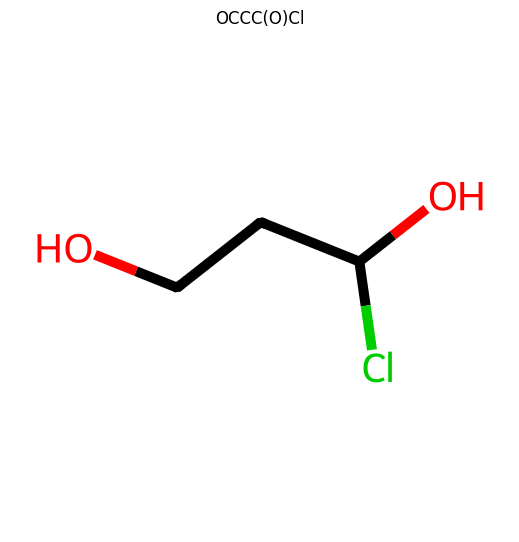

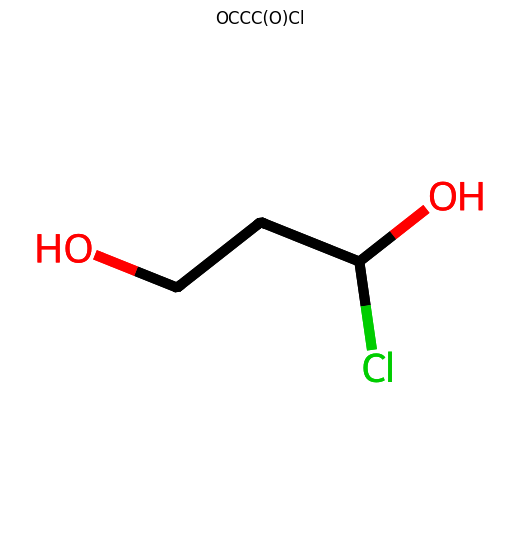

In [26]:
# Get the default drawing options and modify them
drawer = Draw.MolDraw2DCairo(500, 500)  # Create a drawer with desired size
opts = drawer.drawOptions()
opts.bondLineWidth = 10  # Set thicker bond lines

os.makedirs('figures', exist_ok=True)
# Draw the molecule with these options
for i, (smi, pred_m) in enumerate(zip(all_pred_smiles, all_pred_mols)):
    print(f'sample {i}')
    drawer.DrawMolecule(pred_m)
    drawer.FinishDrawing()
    png_data = drawer.GetDrawingText()

    # Convert the PNG data to an image that can be displayed with matplotlib
    img = Image.open(io.BytesIO(png_data))

    # Display with matplotlib
    fig = plt.figure(figsize=(10, 5), frameon=False)
    ax = plt.Axes(fig, [0, 0, 1, 1])
    ax.set_title(smi)
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img)
    name = f'pred_m_{i}_usepe_{use_pe}'
    plt.savefig(f'figures/{name}.pdf', bbox_inches='tight', pad_inches=0, transparent=True)